# Stacking Model Notebook 

### Here we try to Combine the Base Models with a Naive Bayes Master Model

In [1]:
# Pure Code for the Stacking Model with Pipelines
# Import Libraries
import os
import sys
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB

# import own modules
sys.path.append(os.path.join("..", ".."))
from scripts import preprocessing as pp
from scripts import evaluate_models as em

# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

### Set some additional Parameters

In [2]:
# Additional Parameters
# metric
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# defaults
RSEED = 42
cv = 10
n_jobs = -1
verbose = 0

### Load the Dataframe

In [3]:
# path to csv file
path_df = os.path.join("..", "..", "data", "df_deep_sam.csv")

# get features
df = pd.read_csv(path_df)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=['img', 'sp_idx'])
df = df.drop(columns=[col for col in df.columns if "_obj" in col])  # drop 'object' columns

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

# processing
df = df[df["sp_fix_duration_ms_total"] <= 5000]

 -> dataframe has 7598 instances and 44 columns
 -> there are 44 numerical columns
 -> there are 0 categoricals columns


### Load the Baseline Models

In [4]:
# Load the RF model
with open(
    os.path.join("..", "..", "models", "uncalibrated_pipelines", "RF_uncalib.pickle"),
    "rb",
) as f:
    rf_model = pickle.load(f)

# Load the svc model
with open(
    os.path.join("..", "..", "models", "uncalibrated_pipelines", "SVC_uncalib.pickle"),
    "rb",
) as f:
    svc_model = pickle.load(f)

# Load the xgb model
with open(
    os.path.join("..", "..", "models", "uncalibrated_pipelines", "XGB_uncalib.pickle"),
    "rb",
) as f:
    xgb_model = pickle.load(f)

# Do the Train Test Split 

In [5]:
# prepare features and target
X = df.drop("asd", axis=1)
y = df["asd"]

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

train-set has '6485' samples & '43' features
test-set has '732' samples - out of '7217'
  ~ 10.14% of full dataset


# Create Everything we need for the Master Model!
### Here we do everything for Training the Meta Model

### Predict on the Train Set with each Base Model Pipeline - 1 Class Pred and 1 Proba Pred

In [6]:
# 2. Generate predictions using the base models
svc_pred_train = svc_model.predict(X_train)
xgb_pred_train = xgb_model.predict(X_train)
rf_pred_train = rf_model.predict(X_train)

# 2. Generate prediction probabilities using the base models
svc_proba_train = svc_model.predict_proba(X_train)
xgb_proba_train = xgb_model.predict_proba(X_train)
rf_proba_train = rf_model.predict_proba(X_train)

## Do the Same on the Test Set!

In [7]:
# 2. Generate predictions using the base models
svc_pred_test = svc_model.predict(X_test)
xgb_pred_test = xgb_model.predict(X_test)
rf_pred_test = rf_model.predict(X_test)

# 2. Generate prediction probabilities using the base models
svc_proba_test = svc_model.predict_proba(X_test)
xgb_proba_test = xgb_model.predict_proba(X_test)
rf_proba_test = rf_model.predict_proba(X_test)

### Concatenate the predictions to from the Train & Test Set + Same for Proba Predictions

In [8]:

# Build the new Feature Dataframe for the Master Model
X_train_stacked = np.column_stack((svc_pred_train, xgb_pred_train, rf_pred_train))
X_test_stacked = np.column_stack((svc_pred_test, xgb_pred_test, rf_pred_test))

### Same for Probabilities

In [9]:
X_train_stacked_proba = np.column_stack(
    (svc_proba_train, xgb_proba_train, rf_proba_train)
)
X_test_stacked_proba = np.column_stack((svc_proba_test, xgb_proba_test, rf_proba_test))

### Define the Master Modell and a Grid Search param_grid for it

In [10]:
# Define the master model (meta-learner)
master_model = GaussianNB()

# Fit our Master Model with the best Hyperparameters

In [11]:
# Fit the meta-learner with the best parameters
best_master_model = master_model
best_master_model.fit(X_train_stacked_proba, y_train)

GaussianNB()

### Let the Master Model Predict on Train and Test Set

In [12]:
# predict & proba
pred_test = best_master_model.predict(X_test_stacked_proba)
proba_test = best_master_model.predict_proba(X_test_stacked_proba)

pred_train = best_master_model.predict(X_train_stacked_proba)
proba_train = best_master_model.predict_proba(X_train_stacked_proba)

### Evaluate Model Performance

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.731     0.694     0.712      3252
           1      0.707     0.743     0.724      3233

    accuracy                          0.718      6485
   macro avg      0.719     0.718     0.718      6485
weighted avg      0.719     0.718     0.718      6485

f(0.5)-score: 0.714
f(2.0)-score: 0.735

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.706     0.725     0.715       371
           1      0.709     0.690     0.699       361

    accuracy                          0.708       732
   macro avg      0.708     0.707     0.707       732
weighted avg      0.708     0.708     0.708       732

f(0.5)-score: 0.705
f(2.0)-score: 0.694



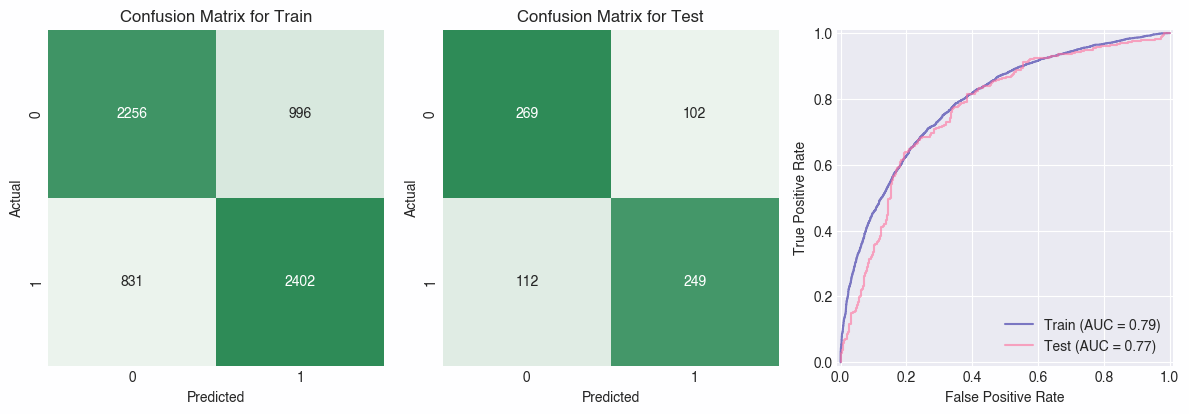

In [13]:
# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

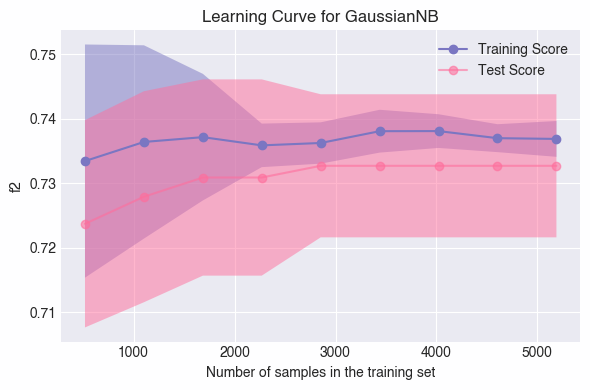

In [14]:
# learning curves - for one model - f2 score
em.learning(best_master_model, X_train_stacked, y_train)

# Store the best Model in a Pickle File

In [15]:
# Save the XGBoost model back to the same pickle file
pickle_file_path = os.path.join(
    "..", "..", "models", "dev", "stacking", "stacking_NB_uncalib.pickle"
)
with open(pickle_file_path, "wb") as f:
    pickle.dump(best_master_model, f)